# Задание 2. Создание подписей к изображениям. Никита Андриянов

Cоздание подписей к изображениям - это задача получения текстовой подписи, описывающей / суммирующей содержимое изображения.

Модели создания подписи к изображениям состоят из 2 основных компонентов: кодировщика CNN (сверточная нейронная сеть) и декодировщика (например, RNN). Кодировщик CNN сохраняет важную информацию об изображении, а декодер будет использовать эту информацию для создания текстовой подписи.

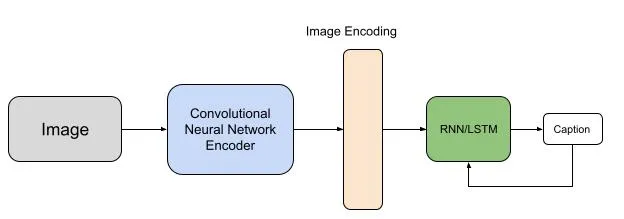

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchtext import data
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil

## Набор данных

Для разработки модели возьмем датасет Flickr 8k. Это стандартный бенчмарк для задачи генерации описания изображений, состоящий из 8000 изображений, каждое из которых сопровождается пятью различными подписями, которые дают четкое описание основных объектов и событий на изображении.

In [3]:
import requests
data_url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1D9XzOLbzcnJ6vVl7L5U-CvSoYBRM7uiv'
r = requests.get(data_url, allow_redirects=True)

In [4]:
open('flickr8k.zip', 'wb').write(r.content)

1112971163

In [5]:
!unzip flickr8k -d ./flickr

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./flickr/Images/2844846111_8c1cbfc75d.jpg  
  inflating: ./flickr/Images/2844963839_ff09cdb81f.jpg  
  inflating: ./flickr/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: ./flickr/Images/2845691057_d4ab89d889.jpg  
  inflating: ./flickr/Images/2845845721_d0bc113ff7.jpg  
  inflating: ./flickr/Images/2846037553_1a1de50709.jpg  
  inflating: ./flickr/Images/2846785268_904c5fcf9f.jpg  
  inflating: ./flickr/Images/2846843520_b0e6211478.jpg  
  inflating: ./flickr/Images/2847514745_9a35493023.jpg  
  inflating: ./flickr/Images/2847615962_c330bded6e.jpg  
  inflating: ./flickr/Images/2847859796_4d9cb0d31f.jpg  
  inflating: ./flickr/Images/2848266893_9693c66275.jpg  
  inflating: ./flickr/Images/2848571082_26454cb981.jpg  
  inflating: ./flickr/Images/2848895544_6d06210e9d.jpg  
  inflating: ./flickr/Images/2848977044_446a31d86e.jpg  
  inflating: ./flickr/Images/2849194983_2968c72832.jpg  
  inflating: ./flick

In [6]:
def get_example(root_imgs, ann_file):
  root_imgs = Path(root_imgs)
  data = pd.read_csv(ann_file)
  img_id = data.sample(1).iloc[0, 0]
  captions = "\n".join(data[data["image"]==img_id]["caption"])
  img = Image.open(root_imgs / img_id)
  return img, captions

def visualize_image_with_captions(img, captions):
  fig, ax = plt.subplots(1, 1)
  ax.imshow(img)
  ax.set_title(captions)

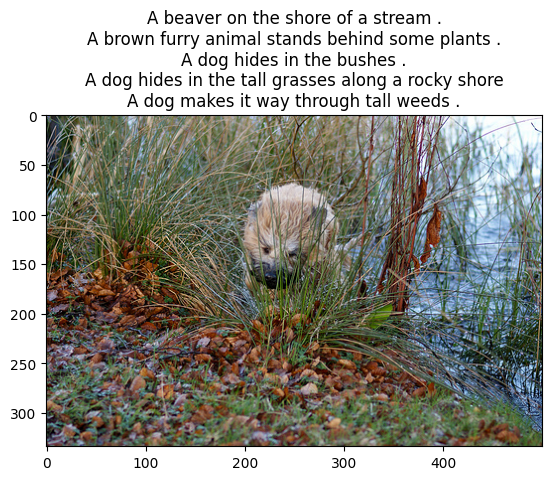

In [7]:
img, captions = get_example(
    root_imgs="/content/flickr/Images",
    ann_file="/content/flickr/captions.txt" ,
)
visualize_image_with_captions(img, captions)

При создании датасета воспользуемся пакетом `torchtext` для построения словаря токенов и `torchvision` для обработки изображений.

In [8]:
class Flickr8k(Dataset):
  def __init__(
      self, 
      root_imgs: str, 
      ann_file: str,
      transform: callable = None, 
      freq_threshold: int = 5
  ):
    self.root_imgs = Path(root_imgs)
    self.annotations = pd.read_csv(ann_file, sep=",")
    self.transform = transform

    self.imgs = self.annotations["image"]
    self.captions = self.annotations["caption"]

    self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
    self.vocab = build_vocab_from_iterator(
        self.yield_tokens(
            self.captions,
            self.tokenizer
        ),
        min_freq=freq_threshold,
        specials=["<SOS>", "<EOS>", "<PAD>", "<UNK>"]
    )
    self.vocab.itos = self.vocab.get_itos()
    self.vocab.stoi = self.vocab.get_stoi()
    self.vocab.set_default_index(self.vocab.stoi["<UNK>"])


  @staticmethod
  def yield_tokens(captions, tokenizer):
    for caption in captions:
      yield tokenizer(caption)

  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, idx):
    caption_text = self.captions[idx]
    img_id = self.imgs[idx]
    img = Image.open(self.root_imgs / img_id)

    if self.transform is not None:
      img = self.transform(img) 

    caption = (
        [self.vocab['<SOS>']] + 
        [self.vocab[token] for token in self.tokenizer(caption_text)] + 
        [self.vocab['<EOS>']]
    )

    return img, torch.tensor(caption)


In [9]:
class Collator:
  def __init__(self, pad_idx: int, batch_first: bool):
    self.pad_idx = pad_idx
    self.batch_first = batch_first

  def __call__(self, batch):
    imgs = torch.stack([item[0] for item in batch], dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(
        targets, 
        batch_first=self.batch_first, 
        padding_value=self.pad_idx
    )
    return imgs, targets

In [10]:
dataset = Flickr8k(
    root_imgs="./flickr/Images",
    ann_file="./flickr/captions.txt" ,
    transform=transforms.Compose([
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)
len(dataset.vocab)

3100

In [11]:
loader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=Collator(
        pad_idx=dataset.vocab.stoi["<PAD>"],
        batch_first=False
    )
)

In [12]:
x, y = next(iter(loader))

In [13]:
x.shape, y.shape

(torch.Size([32, 3, 299, 299]), torch.Size([23, 32]))

## Кодировщик

Самый простой вариант - использовать готовую предобученную модель (например, Inception V3, ResNet, VGG, ...). В данной задаче можно использовать transfer learning вместо того, чтобы обучать модель с нуля, чтобы создать эмбеддинг для изображения, потому что предобученные модели уже умеют выделять самые общие признаки. В то же время какие-то специфичные вещи для конкретной задачи можно будет дотюнить в процессе обучения.

Здесь мы возьмем модель `inception_v3` из пакета `torchvision`. Последний слой модели содержит 1000 значений на выходе. Фактически, это слой-классификатор. Заменим последний слой этой модели для получения эмбеддинга размера `embed_size`.

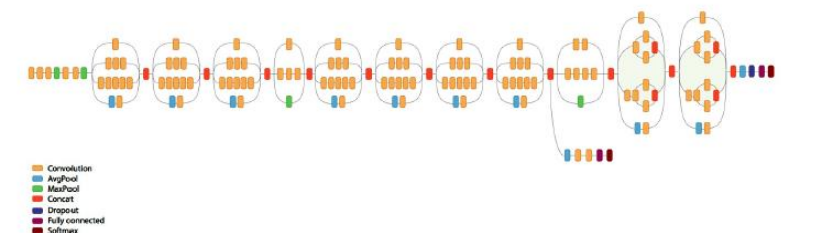

In [14]:
class CNNEncoder(nn.Module):
 def __init__(self, embed_size, trainable: bool = False):
   super(CNNEncoder, self).__init__()
   self.inception = models.inception_v3(
       weights="IMAGENET1K_V1",       
  )
   self.inception.fc = nn.Linear(
       self.inception.fc.in_features,
       embed_size
   )
   self.relu = nn.ReLU()
   self.dropout = nn.Dropout(0.5)
   self.freeze()

 def freeze(self):
    for name, param in self.named_parameters():
      param.requires_grad = "fc.weight" in name or "fc.bias" in name

 def forward(self, images):
   # images: batch_size x 3 x H x W
   features = self.inception(images) # batch_size x embed_size
   if hasattr(features, "logits"):
     features = features.logits 
   return self.dropout(
       self.relu(
           features
       )
   ) 

## Декодировщик

В качестве декодировщика будем использовать рекуррентную нейронную сеть (LSTM). В качестве первого входа слою LSTM будут подаваться признаки, которые извлекает CNN из изображения

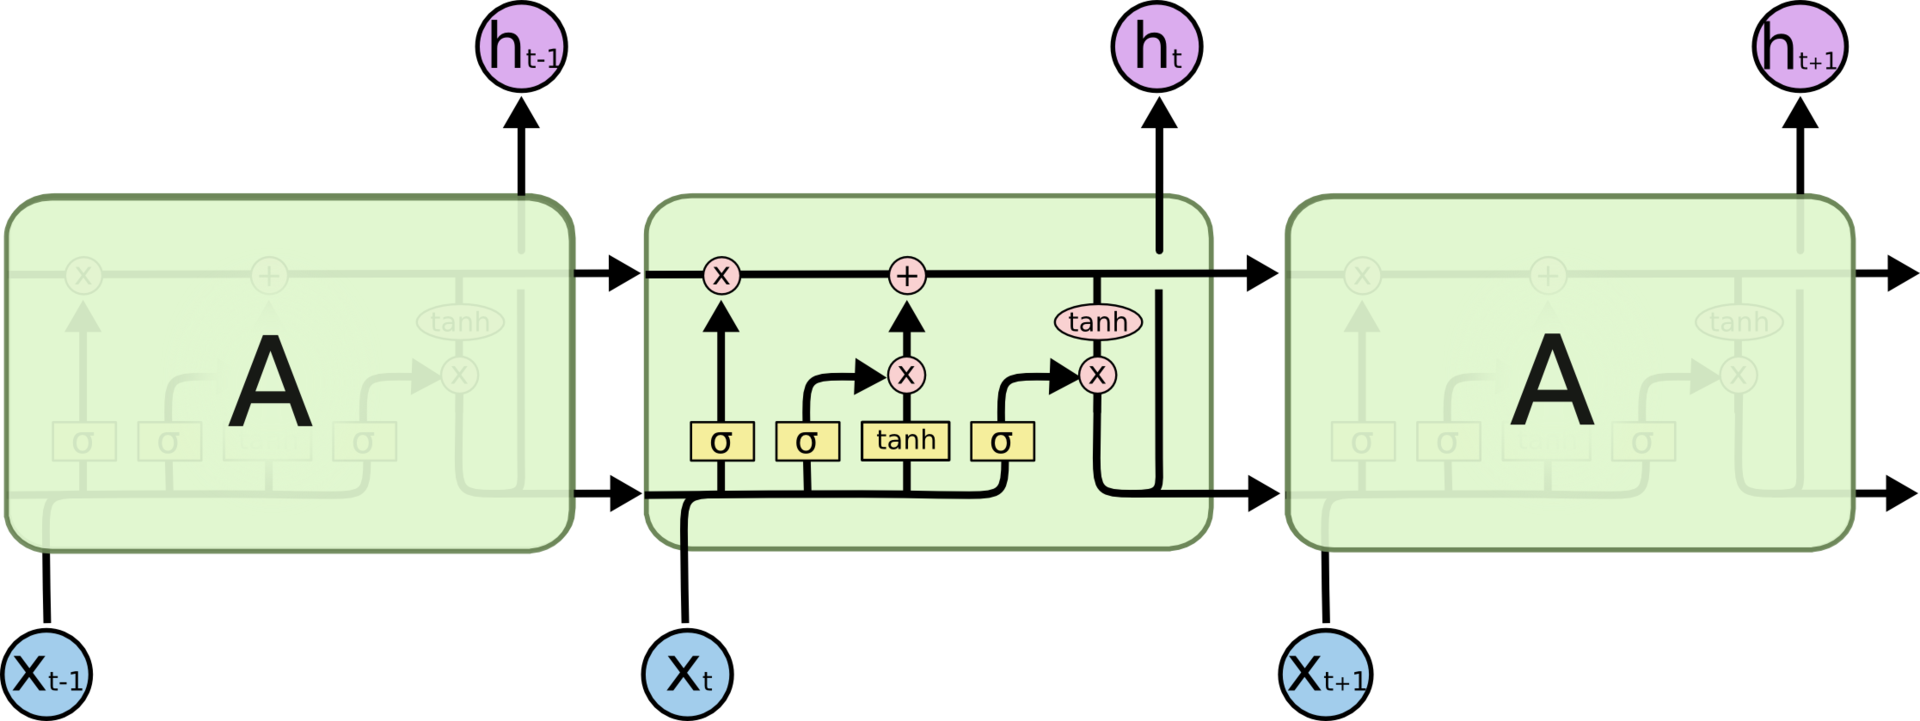

In [15]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(DecoderRNN, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=False)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = self.dropout(self.embed(captions)) # seq_len x batch_size x embed_size 
    # передаем признаки, полученные от кодировщика, в виде первого вектора последовательности
    embeddings = torch.cat(
        (features.unsqueeze(dim=0), embeddings),
        dim=0
    ) # seq_len+1 x batch_size x embed_size 
    hiddens, _ = self.lstm(embeddings) # seq_len+1 x batch_size x embed_size 
    outputs = self.linear(hiddens) # seq_len+1 x batch_size x vocab_size 
    return outputs

## Итоговая модель

Обучение: для каждого изображения в батче предсказываем для каждого токена следующий (распределение на vocab_size классов). Первым на вход декодеру пойдет представление, полученное энкодером (таким образом получается сдвиг).

Инференс: в отличие от процесса обучения на вход на очередном шаге декодировщика попадает не правильный токен, а прогноз, полученный на предыдущем шаге.

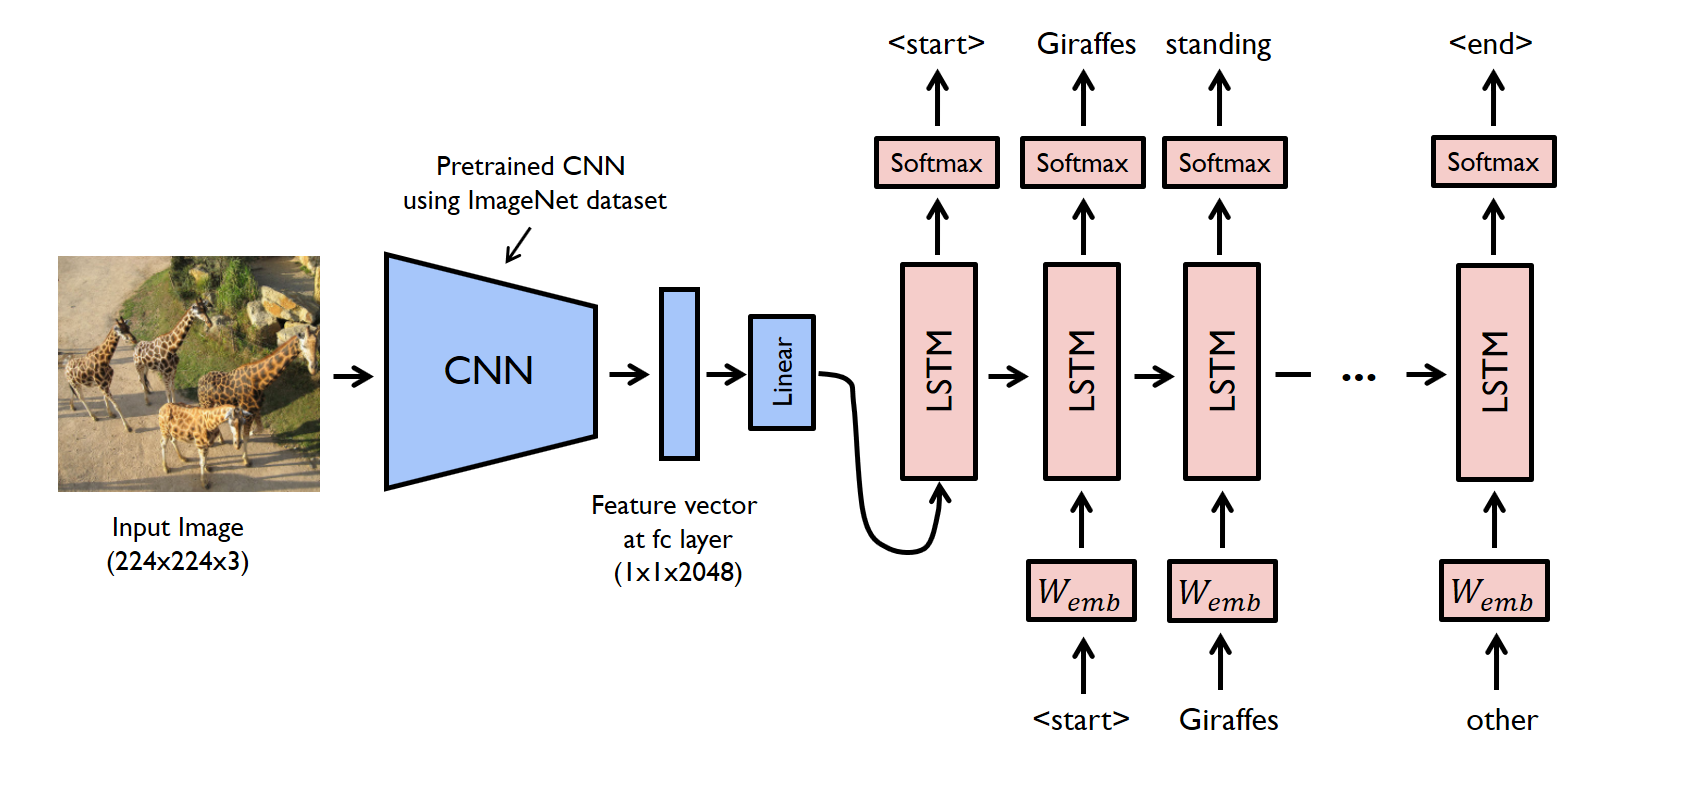

In [16]:
class EncoderDecoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(EncoderDecoder, self).__init__()
    self.encoder = CNNEncoder(embed_size)
    self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

  def forward(self, images, captions):
    features = self.encoder(images) # batch_size x embed_size
    outputs = self.decoder(features, captions) # # seq_len+1 x batch_size x vocab_size 
    return outputs

  def caption_image(self, image, vocabulary, max_length=50):
    # переводим encoder в режим eval, т.к. в режиме обучения
    # он не сможет обработать 1 картинку
    self.encoder.eval()
    result_caption = []
    with torch.no_grad():
      x = self.encoder(image.unsqueeze(dim=0)).unsqueeze(dim=0) # 1 x 1 x embed_size
      
      states = None
      for _ in range(max_length):
        hiddens, states = self.decoder.lstm(x, states) # hiddens: 1 x 1 x hidden_size
        output = self.decoder.linear(hiddens.squeeze(dim=0)) # 1 x vocab_size
        predicted = output.argmax(dim=1) 
        result_caption.append(predicted.item())
        # используем прогноз (а не правильный ответ!) для следующего вызова LSTM
        x = self.decoder.embed(predicted).unsqueeze(dim=0)
        
        if vocabulary.itos[predicted.item()] == "<EOS>":
          break
    self.encoder.train()
    return [vocabulary.itos[idx] for idx in result_caption]

## Обучение

In [17]:
def demo(model):
  model.eval()
  transform = transforms.Compose([
        transforms.Resize((356, 356)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
  for ex_idx in range(1, 6):
      img, captions = get_example(
          root_imgs="./flickr/Images",
          ann_file="./flickr/captions.txt" ,
      )
      img_t = transform(img).to(device)
      prediction = " ".join(model.caption_image(img_t, dataset.vocab))
      print(
          f"EPOCH={epoch} Example #{ex_idx}",
          "CORRECT:",
          captions,
          "PREDICTED:",
          prediction,
          sep="\n"
      )
  model.train()

Будем использовать аугментации изображений

In [18]:
dataset = Flickr8k(
    root_imgs="./flickr/Images",
    ann_file="./flickr/captions.txt" ,
    transform=transforms.Compose([
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

loader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=Collator(
        pad_idx=dataset.vocab.stoi["<PAD>"],
        batch_first=False
    ), 
)
n_batches = ceil(len(dataset) / loader.batch_size)
print(f"{len(dataset.vocab)=} {n_batches=}")

len(dataset.vocab)=3100 n_batches=1265


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 1 #для воспроизводимости, модель обучалась 100 эпох на самом деле

model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss = torch.tensor(9999)
losses = []
for epoch in range(num_epochs):
  acc_loss = 0
  for idx, (imgs, captions) in (pbar := tqdm(enumerate(loader))):
    pbar.set_description(f"{epoch}/{idx} loss={loss.item()}")
    imgs = imgs.to(device)
    captions = captions.to(device)

    outputs = model(imgs, captions[:-1]) # without <EOS>
    loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc_loss += loss.item()

  mean_loss = acc_loss / n_batches
  losses.append(mean_loss)
  print(f"epoch={epoch} mean_loss={mean_loss:.2f}")
  demo(model)
  print("\n\n")
  torch.save(model, "captioning_exp.pt")

0/1264 loss=3.281074047088623: : 1265it [10:09,  2.08it/s]


epoch=0 mean_loss=3.81
EPOCH=0 Example #1
CORRECT:
A black dog in the middle of running or leaping .
A black dog is running quickly along the ground .
A rottweiler running .
The brown and black dog sprints across the snow .
There is a black and tan dog bounding through the air .
PREDICTED:
<SOS> A man in a blue shirt is jumping on a <UNK> . <EOS>
EPOCH=0 Example #2
CORRECT:
A man is skateboarding up a ramp .
A skateboarder hits a curve at the top of the skate park .
The man in a white shirt is skateboarding .
The man performs tricks on his skateboard in the skateboarding park .
The skateboarder in the white t-shirt is riding on a wooden ramp .
PREDICTED:
<SOS> A man in a blue shirt is jumping on a <UNK> . <EOS>
EPOCH=0 Example #3
CORRECT:
A man and a woman walk their dogs on leashes .
Dogs straining on leashes towards each other , as owners walk apart on grass .
The two dogs are being pulled away by their owners .
Two dogs on leashes straining toward each other while their owners walk 

Обучение происходит очень долго, одна эпоха длится около 11 минут. Хотел обучить еще немного, но не успел. Поэтому оставил вывод с одной эпохой, но кривая обучения для 100 эпох сохранилась в рисунке.

Text(0.5, 1.0, 'learning curve')

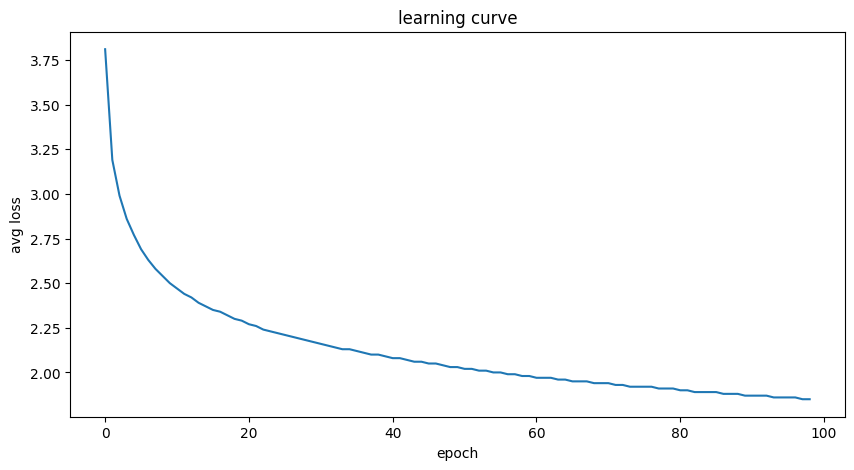

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(losses)
ax.set_xlabel("epoch")
ax.set_ylabel("avg loss")
ax.set_title("learning curve")

Видим, что при обучении достаточно сильно упал Loss

## Инференс и выводы

In [23]:
model = torch.load("captioning_exp_100.pt").cpu()

In [24]:
dataset = Flickr8k(
    root_imgs="./flickr/Images",
    ann_file="./flickr/captions.txt" ,
    transform=transforms.Compose([
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

In [25]:
def test(model, img_f):
  model.eval()
  transform = transforms.Compose([
        transforms.Resize((356, 356)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

  img = Image.open(img_f)
  img_t = transform(img)
  prediction = " ".join(model.caption_image(img_t, dataset.vocab))
  plt.imshow(img)
  plt.title(prediction)

Закинем тестовых изображений

In [47]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
data_url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1jT8XDAWjCxg3jS3-pjTNvXGtOVDWcatv'
r = requests.get(data_url, allow_redirects=True)
open('test.zip', 'wb').write(r.content)
!unzip test -d ./test_data

Archive:  test.zip
   creating: ./test_data/test/
  inflating: ./test_data/test/1.jpg  
  inflating: ./test_data/test/2.jpg  
  inflating: ./test_data/test/3.jpg  
  inflating: ./test_data/test/4.jpg  
  inflating: ./test_data/test/5.jpg  
  inflating: ./test_data/test/6.jpg  


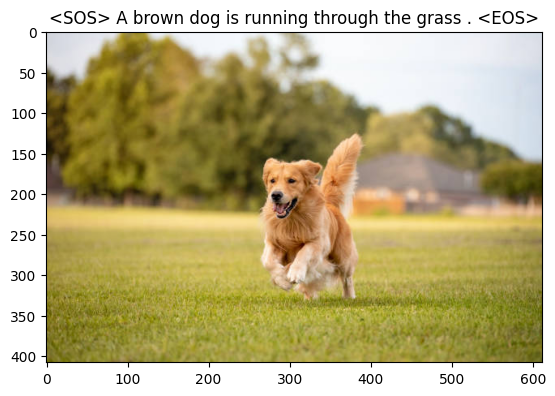

In [50]:
test(model, "./test_data/test/1.jpg")

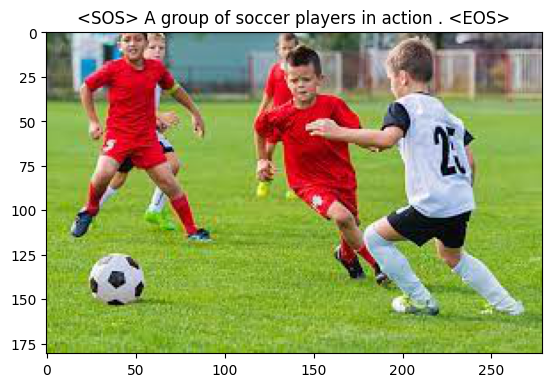

In [51]:
test(model, "./test_data/test/2.jpg")

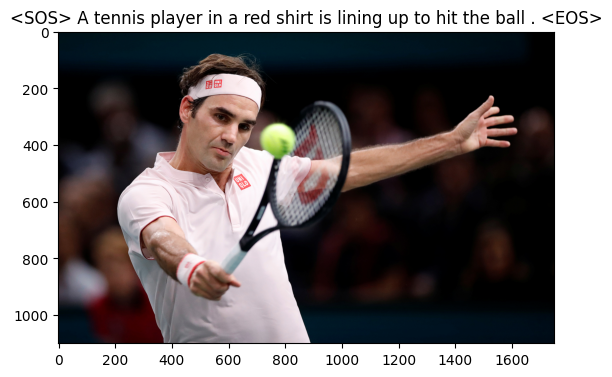

In [52]:
test(model, "./test_data/test/3.jpg")

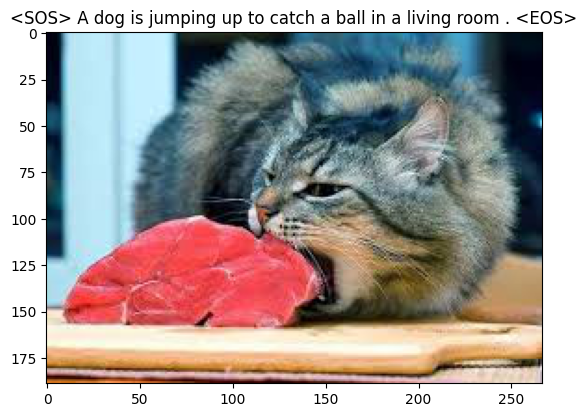

In [53]:
test(model, "./test_data/test/4.jpg")

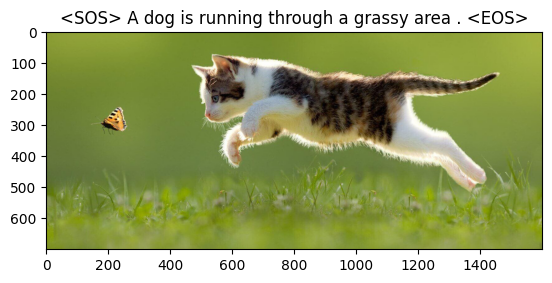

In [54]:
test(model, "./test_data/test/5.jpg")

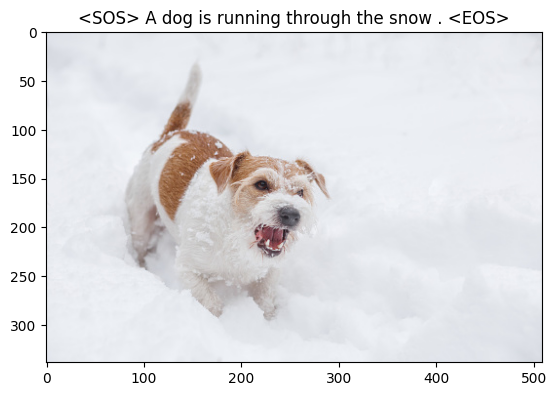

In [55]:
test(model, "./test_data/test/6.jpg")

Была обучена модель генерации описания для изображения. 

Для обучения использован датасет Flickr8. Датасет описывается в виде класса `Flickr8k`, в котором реализована логика загрузки файлов и построения словаря на основе корпуса слов при помощи пакета `torchtext`.

Была создана типовая модель энкодер-декодер, где кодировщиком выступает предобученная сеть inception_v3 с замененным последним линейным слоем, а в качестве декодировщика - рекуррентная сеть.

Модель была обучена в течение 100 эпох. Результаты, которые показывает данная модель на тестовых изображениях, показывают, что
модель была успешно обучена: она может улавливать основные элементы изображения (допуская ошибки в деталях) и генерирует корректный текст на английском языке.

Недостатки решения и направления работы:
* разделить датасет на обучающее и валидационное множество для исследования факта переобучения модели (по-видимому, модель переобучилась на собачках)
* использовать предобученные word embeddings декодировщика для ускорения сходимости модели
* исследование качества модели с применением других рекуррентных слоев (LSTM -> GRU), ожидается более высокую скорость обучения без значимой потери качества

## P.S. Большое спасибо за курс!)

Ссылка на модель и датасеты: https://drive.google.com/drive/folders/18qhzOlDcwHDdgVRDQ4JbxjBtjYNMImQB?usp=sharing 